Final weights: [0.18, 0.24, 0.45], predictionrate: 100.0%


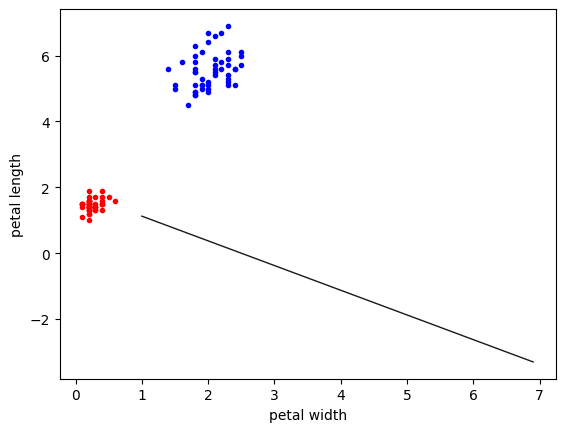

In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt



p_wid = 'petal width'
p_len = 'petal length'

dataset = pd.read_csv('iris.csv', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])

dataset.drop(dataset[dataset['class'] == 'Iris-versicolor'].index, inplace=True)
binary_dataset = dataset.copy()

binary_dataset.drop(['sepal length', 'sepal width'], axis='columns', inplace=True)

binary_dataset.loc[dataset['class'] == 'Iris-setosa', binary_dataset.columns == 'class'] = 0
binary_dataset.loc[dataset['class'] == 'Iris-virginica', binary_dataset.columns == 'class'] = 1


def sigma(x, w):
    activation = -1.0 * w[-1] #bias
    for i in range(len(x) - 1):
        activation += w[i] * x[i]
    return 1.0 if activation >= 0 else 0.0

def training(data, w0, mu, T):
    w = w0
    for idx in range(T):
        for x in data:
            actiavtion = sigma(x, w)
            error = x[-1] - actiavtion
            w[-1] += 1.0 * mu * error

            for i in range(len(x)-1):
                w[i] += mu * error * x[i]
    
    return w

weights = [0.18, 0.24, 0.45]

weights = training(binary_dataset.values, weights, 0.2, 10)

target = 0
prediction = 0

classified_dataset = pd.DataFrame({p_len:[], p_wid:[], 'class':[]})

for sample in binary_dataset.values:
    a = sigma(sample, weights)

    if (float(sample[-1]) == a):
        target += 1
        prediction += 1
    else: target += 1

    sample[-1] = a

    classified_dataset.loc[len(classified_dataset)] = sample


print(f"Final weights: {weights}, predictionrate: {prediction/target * 100 }%")



data_x_setosa = classified_dataset.query('`class` == 0')[p_wid].array
data_y_setosa = classified_dataset.query('`class` == 0')[p_len].array

data_x_virginica = classified_dataset.query('`class` == 1')[p_wid].array
data_y_virginica = classified_dataset.query('`class` == 1')[p_len].array

pull_classified = classified_dataset.to_numpy()

def get_hyperplane(x, w, b, offset):
    return (-w[0] * x - b + offset) / w[1]

x_v = np.amin(pull_classified[:, 0])
x2_v = np.amax(pull_classified[:, 0])

bias = weights[-1] * -1

x_v_1 = get_hyperplane(x_v, weights, bias, 0)
x2_v_2 = get_hyperplane(x2_v, weights, bias, 0)


plt.plot(data_x_setosa, data_y_setosa, ".r")
plt.plot(data_x_virginica, data_y_virginica, ".b" )
plt.plot( [x2_v, x_v], [x2_v_2, x_v_1], "-", c='k', lw=1, alpha=0.9)
plt.xlabel(p_wid)
plt.ylabel(p_len)
plt.show()

In [26]:
class SVM:
    def __init__(self, learning_rate=1e-3, lambda_param=1e-2, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.printcount=0

    def _init_weights_bias(self, X):
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0

    def _get_cls_map(self, y):
        return np.where(y <= 0, -1, 1)

    def _satisfy_constraint(self, x, idx):
        linear_model = np.dot(x, self.w) + self.b 
        return self.cls_map[idx] * linear_model >= 1
    
    def _get_gradients(self, constrain, x, idx):
        if constrain:
            dw = self.lambda_param * self.w
            db = 0
            return dw, db
        
        dw = self.lambda_param * self.w - np.dot(self.cls_map[idx], x)
        db = - self.cls_map[idx]
        return dw, db
    
    def _update_weights_bias(self, dw, db):
        self.w -= self.lr * dw
        self.b -= self.lr * db
    
    def fit(self, X, y):
        self._init_weights_bias(X)
        self.cls_map = self._get_cls_map(y)

        for _ in range(self.n_iters):
            for idx, x in enumerate(X):
                constrain = self._satisfy_constraint(x, idx)
                dw, db = self._get_gradients(constrain, x, idx)
                self._update_weights_bias(dw, db)
    
    def predict(self, X):
        estimate = np.dot(X, self.w) + self.b
        prediction = np.sign(estimate)
        return np.where(prediction == -1, 0, 1)

In [27]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true==y_pred) / len(y_true)
    return accuracy

# hyperplane for plot results
def get_hyperplane(x, w, b, offset):
    return (-w[0] * x - b + offset) / w[1]


SVM Accuracy:  1.0


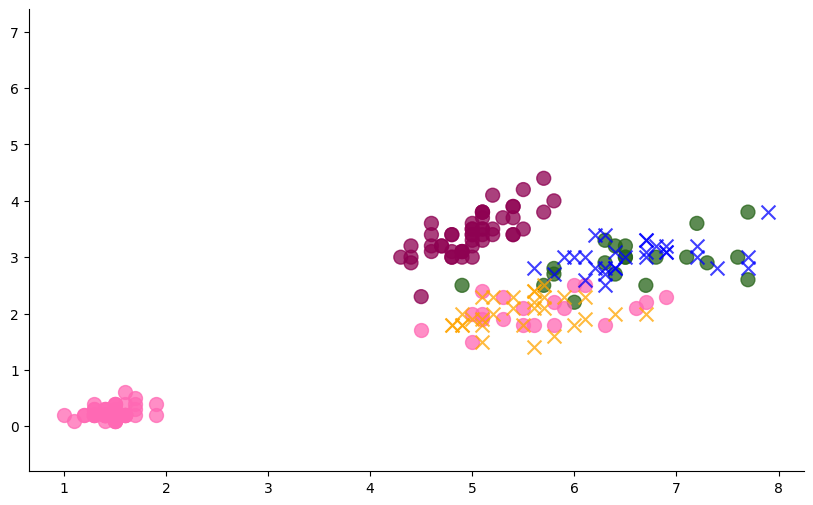

In [29]:

N_ITER = 2000

dataset.loc[dataset['class'] == 'Iris-setosa', dataset.columns == 'class'] = 0
dataset.loc[dataset['class'] == 'Iris-virginica', dataset.columns == 'class'] = 1

classes = dataset['class'].to_numpy()[:70]
test_classes = dataset['class'].to_numpy()[70:100]

features = dataset[['sepal length', 'sepal width', 'petal length', 'petal width']].to_numpy()[:70]
test_features = dataset[['sepal length', 'sepal width', 'petal length', 'petal width']].to_numpy()[70:100]

clf = SVM(n_iters=N_ITER)
clf.fit(features, classes)
predictions = clf.predict(test_features)

print("SVM Accuracy: ", accuracy(test_classes, predictions))
    
fig, ax = plt.subplots(1, 1, figsize=(10,6))

plt.set_cmap('PiYG')
plt.scatter(features[:, 0], features[:, 1], marker='o', c=classes, s=100, alpha=0.75)
plt.scatter(features[:, 2], features[:, 3], marker='o', c='hotpink', s=100, alpha=0.75)
plt.scatter(test_features[:, 0], test_features[:, 1], marker="x", c='blue', s=100, alpha=0.75)
plt.scatter(test_features[:, 2], test_features[:, 3], marker="x", c='orange', s=100, alpha=0.75)

x0_1 = np.amin(features[:, 0])
x0_2 = np.amax(features[:, 0])   

x1_1 = get_hyperplane(x0_1, clf.w, clf.b, 0)
x1_2 = get_hyperplane(x0_2, clf.w, clf.b, 0)

x1_1_m = get_hyperplane(x0_1, clf.w, clf.b, -1)
x1_2_m = get_hyperplane(x0_2, clf.w, clf.b, -1)

x1_1_p = get_hyperplane(x0_1, clf.w, clf.b, 1)
x1_2_p = get_hyperplane(x0_2, clf.w, clf.b, 1)

ax.plot([x0_1, x0_2], [x1_1, x1_2], "-", c='k', lw=1, alpha=0.9)
ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "--", c='grey', lw=1, alpha=0.8)
ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "--", c='grey', lw=1, alpha=0.8)

dataset_without_class = dataset.drop(dataset['class'])

dataset_numpy = dataset_without_class.to_numpy()

x1_min = np.amin(dataset_numpy[:, 1])
x1_max = np.amax(dataset_numpy[:, 1])
ax.set_ylim([x1_min - 3, x1_max + 3])

for spine in ['top','right']:
    ax.spines[spine].set_visible(False)

plt.show()